# Spam Classification
## Table of Contents
### 0. Setup
### 1. Exploratory Data Analysis
### 2. Data Preprocessing
### 3. Model Training
### 4. Model Selection
### 5. Final Prediction

## 0. Setup

In [1]:
# basics
import re
import pandas as pd
import numpy as np
import os
import argparse
import string
import nltk

# visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer, PunktSentenceTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.data import find
from sklearn.preprocessing import StandardScaler

# models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ignore convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# load data
train_df = pd.read_csv('raw-dataset/train.csv')
test_df = pd.read_csv('raw-dataset/test.csv')

## 1. Exploratory Data Analysis

### 1.1 Basic Information

### 1.2 Date

### 1.3 Video

### 1.4 User

### 1.5 Comment

## 2. Data Preprocessing

### 2.1 Feature Engineering

In [3]:
# date column into binary
train_df['DATE'] = train_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)

### 2.2 Basic Tokenization

In [4]:
# basic functions
def clean_text1(text):
    # Remove '\ufeff' if present
    text = text.replace('\ufeff', '')
    # Remove punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))
    # filter out stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

def clean_text2(text):
    text = text.replace('www', ' www ')
    text = text.replace('https', ' https ')
    text = text.replace('  ', ' ')
    return text

def tokenize(text):
    sentence_tokenizer = TreebankWordTokenizer()
    lemmatizer = WordNetLemmatizer()
    tokenized_text = sentence_tokenizer.tokenize(text.lower())
    final = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return final

def count_vect(text):
    return ' '.join(text)

def clean_text(text):
    text = clean_text1(text)
    text = clean_text2(text)
    text = tokenize(text)
    return count_vect(text)

In [5]:
train_df['cleaned_text'] = train_df['CONTENT'].apply(clean_text)

### 2.3 Word Vectorization: CountVectorizer

In [6]:
count_vectorizer = CountVectorizer()
x_1 = count_vectorizer.fit_transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x_count_vect = np.hstack((x_1, x_2))
y = train_df['CLASS']

### 2.4 Word Vectorization: TF-IDF Vectorizer

In [7]:
tf_vectorizer = TfidfVectorizer()
x_1 = tf_vectorizer.fit_transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x_tf_idf = np.hstack((x_1, x_2))
y = train_df['CLASS']

## 3. Model Development and Training

### 3.1 Linear Separability: Principal Component Analysis

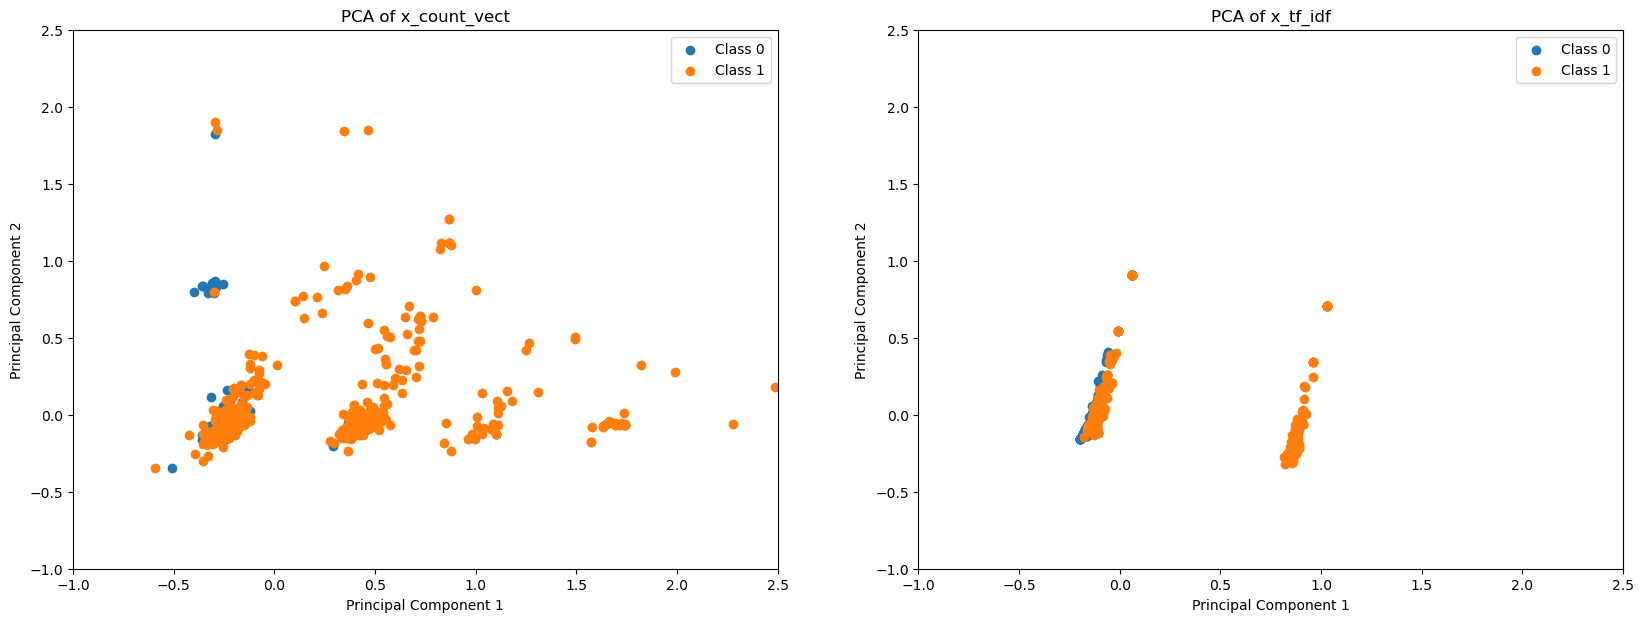

In [8]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# count vectorizer
pca_count_vect = PCA(n_components=2)
x_pca_count_vect = pca_count_vect.fit_transform(x_count_vect)


# Plot for count vectorizer
axes[0].set_title('PCA of x_count_vect')
for class_value in np.unique(y):
    axes[0].scatter(x_pca_count_vect[y == class_value, 0], x_pca_count_vect[y == class_value, 1], label=f'Class {class_value}')
axes[0].set_xlim(-1, 2.5)
axes[0].set_ylim(-1, 2.5)
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend()

# tf_idf
pca_tf_idf = PCA(n_components=2)
x_pca_tf_idf = pca_tf_idf.fit_transform(x_tf_idf)

# Plot for tf_idf
axes[1].set_title('PCA of x_tf_idf')
for class_value in np.unique(y):
    axes[1].scatter(x_pca_tf_idf[y == class_value, 0], x_pca_tf_idf[y == class_value, 1], label=f'Class {class_value}')
axes[1].set_xlim(-1, 2.5)
axes[1].set_ylim(-1, 2.5)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].legend()

plt.show()

### 3.2 Linear Separability: Hard Margin Support Vector Machine

#### Count Vectorizer

In [9]:
x_c_train, x_c_test, y_c_train, y_c_test = train_test_split(x_count_vect, y, test_size=0.2)

In [10]:
hard_margin_svm = SVC(kernel='linear', C=100000000000)

hard_margin_svm.fit(x_c_train, y_c_train)
y_c_pred = hard_margin_svm.predict(x_c_test)

count_vector_hard_margin_svm_accuracy_score = accuracy_score(y_c_test, y_c_pred)
count_vector_hard_margin_svm_accuracy_score

0.9233576642335767

#### TF-IDF

In [11]:
x_t_train, x_t_test, y_t_train, y_t_test = train_test_split(x_tf_idf, y, test_size=0.2)

In [12]:
# tf_idf
hard_margin_svm = SVC(kernel='linear', C=100000000000)

hard_margin_svm.fit(x_t_train, y_t_train)
y_pred = hard_margin_svm.predict(x_t_test)

tf_idf_hard_margin_svm_accuracy_score = accuracy_score(y_t_test, y_pred)
tf_idf_hard_margin_svm_accuracy_score


0.9343065693430657

### 3.3 Model Hyperparameter Tuning

#### Count Vectorizer

In [ ]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 1000, 10000]
}

c_grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')
c_grid_search.fit(x_c_train, y_c_train)
c_grid_search.best_params_

In [ ]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 1000, 10000]
}

t_grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')
t_grid_search.fit(x_t_train, y_t_train)
t_grid_search.best_params_

### 3.4 Model Comparison

/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sta314/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_ite

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [100, 1000, 10000],
                         'solver': ['lbfgs', 'saga']},
             scoring='accuracy')

{'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}

## 4. Model Evaluation

## 5. Final Prediction 